# Midterm for INF2178H

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.anova as smsa
import statsmodels.stats.weightstats as smsw
from pingouin import ancova
from statsmodels.stats.power import TTestIndPower
%matplotlib inline

## Loading and cleaning data

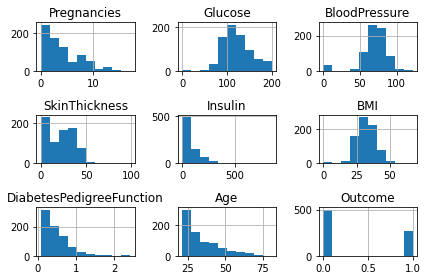

In [5]:
data = pd.read_csv('diabetes.csv')
data.hist()
plt.tight_layout()

In [6]:
# Fill zeros with median value
data.loc[data.Insulin == 0, 'Insulin'] = data.Insulin[data.Insulin > 0].median()
data.loc[data.BMI == 0, 'BMI'] = data.BMI[data.BMI > 0].median()
data.loc[data.Glucose == 0, 'Glucose'] = data.Glucose[data.Glucose > 0].median()
data.loc[data.SkinThickness == 0, 'SkinThickness'] = data.SkinThickness[data.SkinThickness > 0].median()
data.loc[data.BloodPressure == 0, 'BloodPressure'] = data.BloodPressure[data.BloodPressure > 0].median()
# Remove large outliers
data = data[(data.Insulin < 400) & (data.SkinThickness < 70)].copy()
data.hist(ax=plt.figure(figsize=(8, 8)))
plt.tight_layout()

/var/folders/x4/yg8647_n1yj0v00kzt9hz82m0000gn/T/ipykernel_12773/94720129.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data.hist(ax=plt.figure(figsize=(8, 8)))


In [7]:
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   747.000000  747.000000     747.000000     747.000000  747.000000   
mean      3.862115  120.475234      72.378849      28.871486  130.140562   
std       3.379245   29.785612      12.133627       8.351981   55.530711   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      25.000000  120.000000   
50%       3.000000  116.000000      72.000000      29.000000  125.000000   
75%       6.000000  138.500000      80.000000      32.000000  125.000000   
max      17.000000  199.000000     122.000000      63.000000  392.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  747.000000                747.000000  747.000000  747.000000  
mean    32.351406                  0.467554   33.186078    0.341365  
std      6.867299                  0.320969   11.684591    0.474485  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.450000                  0.243500   24.000000    0.000000  
50%     32.300000                  0.368000   29.000000    0.000000  
75%     36.450000                  0.625000   40.500000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

## Exploratory Analysis

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


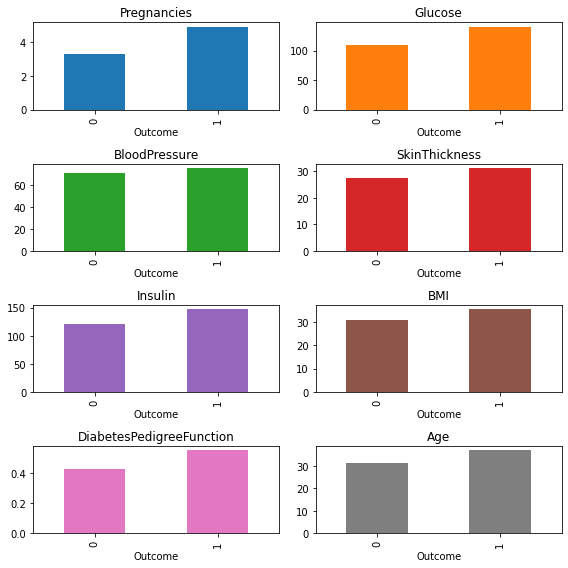

In [8]:
# Bar plot of mean values
data_group = data.groupby('Outcome').aggregate(np.mean)
data_group.plot.bar(subplots=True, layout=(4, 2), legend=False, ax=plt.figure(figsize=(8, 8)))
plt.tight_layout()

In [9]:
# T-tests for correlations
variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
ttests = {
    't-statistic': [],
    'p-value': [],
    'df': [],
}
for x in variables:
    t = smsw.ttest_ind(*data.groupby('Outcome')[x].apply(list))
    ttests['t-statistic'].append(t[0])
    ttests['p-value'].append(t[1])
    ttests['df'].append(t[2])

pd.DataFrame(ttests, index=variables)

t-statistic       p-value     df
Pregnancies                 -6.427175  2.319467e-10  745.0
Glucose                    -15.294466  3.976390e-46  745.0
BloodPressure               -4.816737  1.768224e-06  745.0
SkinThickness               -5.881823  6.126739e-09  745.0
Insulin                     -6.155403  1.223033e-09  745.0
BMI                         -9.268462  1.990781e-19  745.0
DiabetesPedigreeFunction    -5.025545  6.291419e-07  745.0
Age                         -6.438417  2.162457e-10  745.0

## Modeling

### Linear analysis

In [10]:
model = smf.ols('Outcome ~ Pregnancies + Glucose + Insulin + BMI + DiabetesPedigreeFunction + Age', data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     59.04
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           1.02e-59
Time:                        11:59:16   Log-Likelihood:                -356.45
No. Observations:                 747   AIC:                             726.9
Df Residuals:                     740   BIC:                             759.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0903      0.087    -12.502      0.000      -1.262      -0.919
Pregnancies                  0.0213      0.005      4.179      0.000       0.011       0.031
Glucose                      0.0064      0.001     11.636      0.000       0.005       0.007
Insulin                  -3.546e-05      0.000     -0.125      0.901      -0.001       0.001
BMI                          0.0147      0.002      6.753      0.000       0.010       0.019
DiabetesPedigreeFunction     0.1562      0.046      3.430      0.001       0.067       0.246
Age                          0.0011      0.002      0.708      0.479      -0.002       0.004
==============================================================================
Omnibus:                       34.085   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.365
Skew:                           0.368   Prob(JB):                     1.88e-06
Kurtosis:                       2.446   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
coefs = pd.DataFrame({
    'coefficient': result.params,
    'standard error': result.bse,
    'p-value': result.pvalues
})
coefs

coefficient  standard error       p-value
Intercept                   -1.090329        0.087214  1.128725e-32
Pregnancies                  0.021277        0.005092  3.281980e-05
Glucose                      0.006405        0.000550  7.382517e-29
Insulin                     -0.000035        0.000284  9.005975e-01
BMI                          0.014652        0.002170  2.926081e-11
DiabetesPedigreeFunction     0.156203        0.045541  6.372051e-04
Age                          0.001068        0.001510  4.793860e-01

Text(0, 0.5, 'Residual')

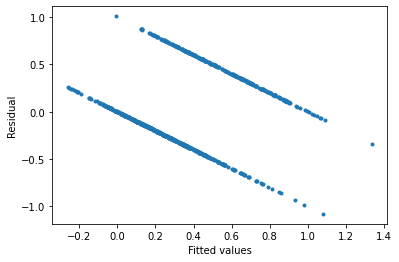

In [12]:
plt.plot(result.fittedvalues, result.resid, '.')
plt.xlabel('Fitted values')
plt.ylabel('Residual')

In [13]:
ax = result.resid.hist()
ax.set_xlabel('Residual')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

### ANOVA

In [14]:
anova = smsa.anova_lm(result, type=1)
anova

df      sum_sq    mean_sq           F  \
Pregnancies                 1.0    8.823317   8.823317   57.484802   
Glucose                     1.0   35.512926  35.512926  231.370291   
Insulin                     1.0    0.080063   0.080063    0.521620   
BMI                         1.0    8.028272   8.028272   52.305000   
DiabetesPedigreeFunction    1.0    1.848085   1.848085   12.040460   
Age                         1.0    0.076863   0.076863    0.500767   
Residual                  740.0  113.582281   0.153490         NaN   

                                PR(>F)  
Pregnancies               1.022048e-13  
Glucose                   1.148730e-45  
Insulin                   4.703796e-01  
BMI                       1.188452e-12  
DiabetesPedigreeFunction  5.507437e-04  
Age                       4.793860e-01  
Residual                           NaN

# ANCOVA

In [16]:
ancova(data, dv='Outcome', covar='BMI', between='Glucose')

Source          SS   DF          F         p-unc       np2
0   Glucose   48.144077  132   2.182448  2.135910e-10  0.319708
1       BMI    7.642835    1  45.732975  3.165748e-11  0.069426
2  Residual  102.443761  613        NaN           NaN       NaN

# Power analysis

In [24]:
# Calculate Cohen's d between two samples
def cohen(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return np.abs(x1.mean() - x2.mean()) / s

In [31]:
# Effect size
insulin0 = data[data.Outcome == 0]['Insulin']
insulin1 = data[data.Outcome == 1]['Insulin']
age0 = data[data.Outcome == 0]['Age']
age1 = data[data.Outcome == 1]['Age']
insulin_d = cohen(insulin0, insulin1)
print(insulin_d)

age_d = cohen(age0, age1)
print(age_d)

0.474967815136668
0.49680591402152174


In [34]:
ptest = TTestIndPower()
age_size = ptest.solve_power(effect_size=age_d, power=0.95, alpha=0.05)
print(age_size)
insulin_size = ptest.solve_power(effect_size=insulin_d, power=0.95, alpha=0.05)
print(insulin_size)

106.26885616011134
116.17347612457056
